# **Importing Twitter Sentimental Dataset**

In [5]:
# api to fecth the dataset
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 80% 65.0M/80.9M [00:00<00:00, 122MB/s]
100% 80.9M/80.9M [00:00<00:00, 127MB/s]


In [6]:
#extracting the comp. file

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset , 'r') as zip:
  zip.extractall()
  print('done..')

done..


# **Importing Libraries**


In [1]:
import numpy as np
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pickle
import nltk


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
print(stopwords.words('english')) # remove this words from the data cuz this words dont have importance wrt our model.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# **Data Processing**

In [7]:
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding  = 'ISO-8859-1')

In [8]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [9]:
twitter_data.shape

(1599999, 6)

In [10]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


# **Our data is considering first row as col names , so we need to change it**

In [11]:
#naming the column
column_names = ['target' , 'id' , 'date' , 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names = column_names ,encoding  = 'ISO-8859-1')

In [12]:
twitter_data.shape

(1600000, 6)

In [13]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
twitter_data.isna().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [15]:
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


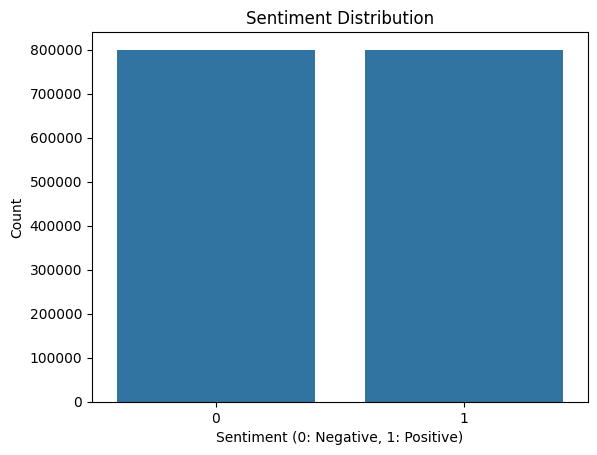

In [70]:
# Sentiment Distribution
sns.countplot(data=twitter_data, x='target')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

**0 -> negative tweet**

**4 -> positive tweet**

 **Data is not imbalanced so no need to modify it ***

In [16]:
twitter_data.replace({'target' : {4:1}}, inplace = True)

In [17]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


**Stemming**

stemming is the process of reducing a word to its Root Word
ex: actor , actress , acting == **act**

In [18]:
port_stem = PorterStemmer()


In [19]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-z]', ' ',  content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

***In above funtion***

- first we removed all special char and numbers.
- then lowercase
- split the sentence in orter to check the words for stemming
- checked the words , if word is present in stopwords perform
  join operation below.

In [20]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

Took 50 mins to run💀

In [48]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [49]:
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [50]:
print(X)
print(Y)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']
[0 0 0 ... 1 1 1]


In [51]:
X_train , X_test,  Y_train , Y_test = train_test_split(X , Y , test_size = 0.2 , stratify=Y , random_state=2)

In [52]:
# feature extraction (CONVERTING TEXT TO NUM)
# TfidfVectorizer() will give values to +ve & -ve tweets
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [53]:
print(X_train)

  (0, 458421)	0.27228112326228093
  (0, 372989)	0.3583819096048567
  (0, 194823)	0.5274064910069903
  (0, 116318)	0.3749338694119814
  (0, 247667)	0.4215060595161854
  (0, 464940)	0.4483581441053542
  (1, 169453)	1.0
  (2, 116318)	0.45905705320412793
  (2, 132152)	0.1891875792321668
  (2, 427967)	0.18706371586911208
  (2, 137276)	0.29069581876534506
  (2, 427034)	0.32103058232997417
  (2, 455221)	0.3296073093697297
  (2, 83506)	0.31303964332256906
  (2, 465311)	0.33480686186877023
  (2, 281186)	0.24137202118772233
  (2, 429906)	0.15168139293444055
  (2, 187474)	0.16194060015844067
  (2, 159240)	0.18800868496584808
  (2, 140239)	0.20289994039686138
  (2, 304223)	0.1678648733603879
  (3, 427034)	0.29025988953598614
  (3, 167435)	0.44570129071167713
  (3, 160331)	0.2785087322306358
  (3, 61032)	0.52009780709937
  :	:
  (1279996, 335154)	0.21190629789318696
  (1279996, 455685)	0.27108924963905606
  (1279996, 409874)	0.21996814268672968
  (1279996, 392260)	0.3596073367651944
  (1279996, 250

In [54]:
print(X_test)

  (0, 17977)	0.17180827032540266
  (0, 34872)	0.16236726920078096
  (0, 72943)	0.2678484639307855
  (0, 112919)	0.367081693610678
  (0, 140294)	0.25509664355434203
  (0, 146252)	0.23682534421364126
  (0, 180544)	0.2803743470609849
  (0, 285841)	0.4532311769636366
  (0, 294440)	0.17813419553395948
  (0, 408024)	0.21977439030363208
  (0, 419078)	0.34884649404705365
  (0, 429906)	0.3140986667345934
  (0, 442233)	0.17903569516819148
  (1, 8801)	0.30376315944222493
  (1, 17977)	0.2084958588978494
  (1, 153709)	0.5722666578553444
  (1, 229396)	0.40557814327518943
  (1, 270721)	0.28432607616832933
  (1, 366102)	0.4820488545932507
  (1, 385085)	0.24302725359248564
  (2, 25826)	0.3529227215218366
  (2, 38175)	0.37941511785250515
  (2, 95488)	0.363168936008175
  (2, 192882)	0.5885804190746107
  (2, 270795)	0.2562344190631401
  :	:
  (319994, 465688)	0.27802041016790324
  (319995, 114775)	0.3338149615345875
  (319995, 116391)	0.301928166814025
  (319995, 164141)	0.27692991319244975
  (319995, 224

**MODEL BUILDING -: LOGISTIC REGRESSION**

In [55]:
model = LogisticRegression(max_iter=1000) # max_iter will iterate 1000 time on data till it reaches a good accuracy

In [56]:
model.fit(X_train , Y_train)

LogisticRegression(max_iter=1000)

**Model Evaluation**

In [57]:
# accuracy score on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train ,X_train_prediction)

In [58]:
print('Accuracy Score on Training Data : ' , training_data_accuracy)

Accuracy Score on Training Data :  0.79812734375


In [59]:
# accuracy score on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test ,X_test_prediction)

In [60]:
print('Accuracy Score on Test Data : ' , test_data_accuracy)

Accuracy Score on Test Data :  0.777265625


**Model Accuracy = 77.8%**

In [61]:
import pickle

**Save the model using pickle**

In [62]:
filename = 'train_model.sav'
pickle.dump(model , open(filename, 'wb'))

**now load the model**

In [63]:
loaded_model = pickle.load(open ('/content/train_model.sav', 'rb'))

In [64]:
X_new = X_test[200]
print(Y_test[200])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet 😡')

else:
  print('Positive Tweet 😘')

1
[1]
Positive Tweet 😘


In [65]:
X_new = X_test[2]
print(Y_test[2])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet 😡')

else:
  print('Positive Tweet 😘')

0
[0]
Negative Tweet 😡


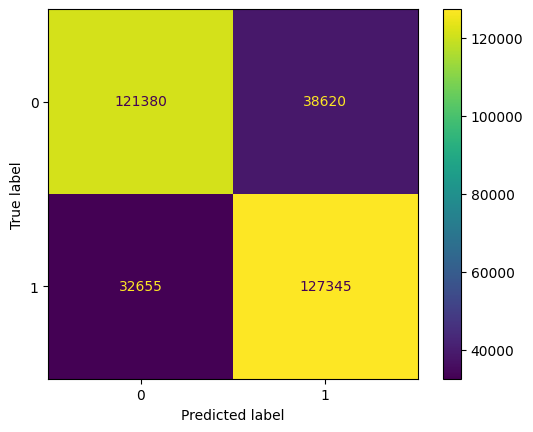

In [66]:
# Confusion Matrix
cm = confusion_matrix(Y_test, X_test_prediction)
ConfusionMatrixDisplay(cm).plot()

In [67]:

# Classification Report
print(classification_report(Y_test, X_test_prediction))


              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



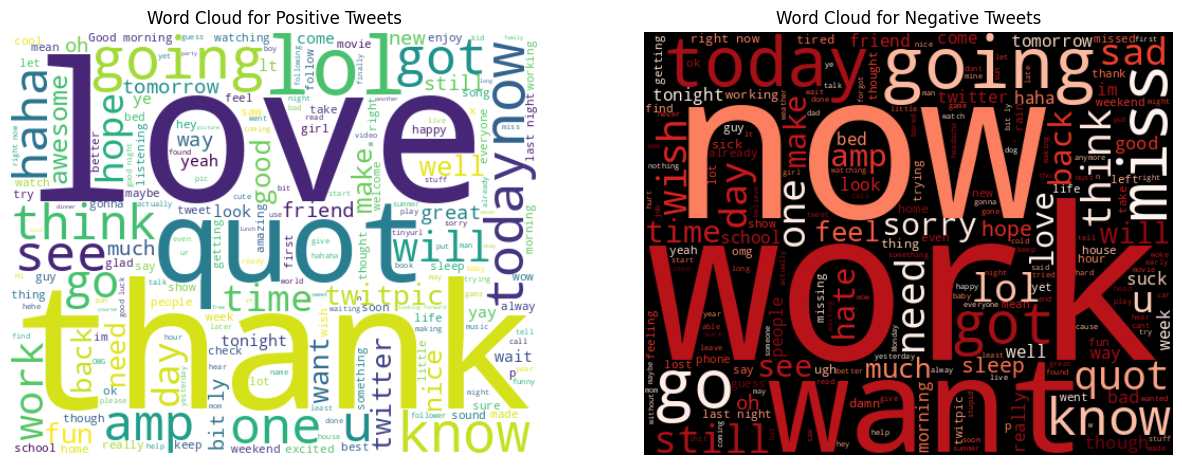

In [71]:
from wordcloud import WordCloud

# Positive and Negative Tweets text
positive_tweets = ' '.join(twitter_data[twitter_data['target'] == 1]['text'])
negative_tweets = ' '.join(twitter_data[twitter_data['target'] == 0]['text'])

# Generate Word Clouds
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

wordcloud_pos = WordCloud(width=500, height=400, background_color='white').generate(positive_tweets)
ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].set_title('Word Cloud for Positive Tweets')
ax[0].axis('off')

wordcloud_neg = WordCloud(width=500, height=400, background_color='black', colormap='Reds').generate(negative_tweets)
ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].set_title('Word Cloud for Negative Tweets')
ax[1].axis('off')

plt.show()


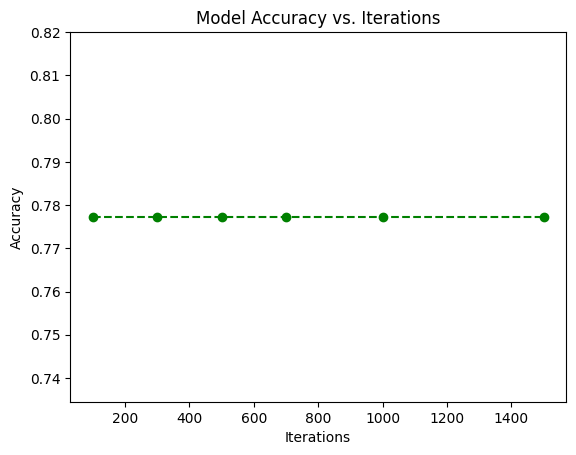

In [72]:

iterations = [100, 300, 500, 700, 1000,1500]
accuracies = []

for max_iter in iterations:
    temp_model = LogisticRegression(max_iter=max_iter)
    temp_model.fit(X_train, Y_train)
    y_temp_pred = temp_model.predict(X_test)
    acc = accuracy_score(Y_test, y_temp_pred)
    accuracies.append(acc)

# Plotting the convergence graph
plt.plot(iterations, accuracies, marker='o', linestyle='--', color='g')
plt.title('Model Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()


In [73]:
# Get feature names and model coefficients
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_[0]

# Top positive and negative words
top_positive = np.argsort(coef)[-10:]
top_negative = np.argsort(coef)[:10]

print("Top Positive Words:")
for i in top_positive:
    print(f"{feature_names[i]}: {coef[i]}")

print("\nTop Negative Words:")
for i in top_negative:
    print(f"{feature_names[i]}: {coef[i]}")


Top Positive Words:
congrat: 4.643288397050303
yayyy: 4.663017741491449
pleasur: 4.85507504695119
hehe: 4.903986393050702
reliev: 4.969801355898109
congratul: 5.056347984061363
iamsoannoy: 5.212325193173504
smile: 5.793394597237308
welcom: 7.079472667668807
thank: 7.86260042601437

Top Negative Words:
sad: -12.19449106943535
poor: -9.364261578056668
miss: -8.829694293016969
sadden: -7.861817939219914
sadli: -7.569756159343508
unfair: -7.113160200895272
saddest: -6.8915382216352965
unfortun: -6.771004098509428
suck: -6.6802712784428095
wish: -6.68007806314897


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:54:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression Accuracy: 77.73%
SVM Accuracy: 54.36%
XGBoost Accuracy: 73.95%


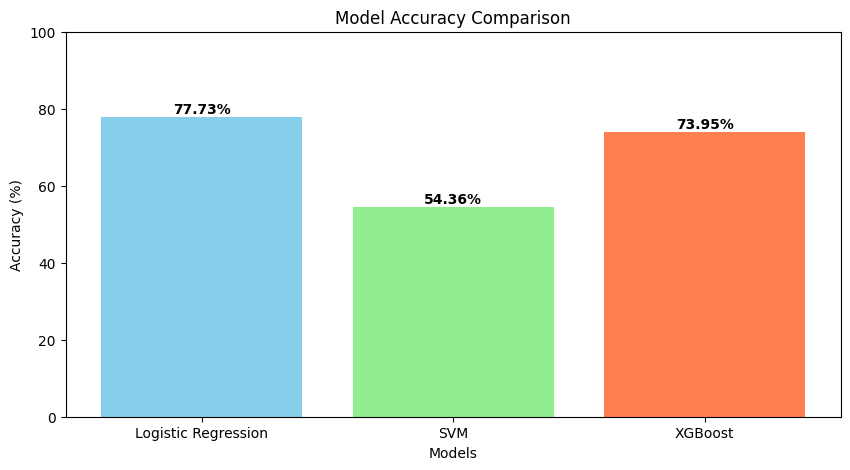

In [74]:
# Required Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize Models
log_reg = LogisticRegression(max_iter=1000)
svm_model = SVC(kernel='linear', max_iter=1000)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the Models
log_reg.fit(X_train, Y_train)
svm_model.fit(X_train, Y_train)
xgb_model.fit(X_train, Y_train)

# Make Predictions
y_pred_log = log_reg.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Accuracy
acc_log = accuracy_score(Y_test, y_pred_log)
acc_svm = accuracy_score(Y_test, y_pred_svm)
acc_xgb = accuracy_score(Y_test, y_pred_xgb)

# Display Accuracy Scores
print(f'Logistic Regression Accuracy: {acc_log * 100:.2f}%')
print(f'SVM Accuracy: {acc_svm * 100:.2f}%')
print(f'XGBoost Accuracy: {acc_xgb * 100:.2f}%')

# Create a Chart to Compare the Models
models = ['Logistic Regression', 'SVM', 'XGBoost']
accuracies = [acc_log * 100, acc_svm * 100, acc_xgb * 100]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'coral'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.show()
